In [1]:
author="Jumabek Alikhanov"
date = 'Nov 17,2019'

This is Final Project material for the "Deep Learning" class I took  

## Download the dataset from https://www.unb.ca/cic/datasets/ids-2017.html
We only need CSV files that is preprocessed and labeled for ML 

In [2]:
#imports
import os
from os.path import join
import glob
import pandas as pd
import numpy as np
%load_ext autoreload

In [3]:
# load data
dataroot = '/media/juma/code/courses/Semester3/DeepLearning/intrusion_detection/MachineLearningCVE/'

In [4]:
def read_data(dataroot,file_ending):
    if file_ending==None:
        print("please specify file ending pattern for glob")
        exit()
    print(join(dataroot,file_ending))
    filenames = [i for i in glob.glob(join(dataroot,file_ending))]
    combined_csv = pd.concat([pd.read_csv(f) for f in filenames],sort=False)
    return combined_csv

In [5]:
data = read_data(dataroot,'*.pcap_ISCX.csv')


/media/juma/code/courses/Semester3/DeepLearning/intrusion_detection/MachineLearningCVE/*.pcap_ISCX.csv


/home/juma/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/juma/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2830743 entries, 0 to 692702
Data columns (total 79 columns):
 Destination Port               int64
 Flow Duration                  int64
 Total Fwd Packets              int64
 Total Backward Packets         int64
Total Length of Fwd Packets     int64
 Total Length of Bwd Packets    int64
 Fwd Packet Length Max          int64
 Fwd Packet Length Min          int64
 Fwd Packet Length Mean         float64
 Fwd Packet Length Std          float64
Bwd Packet Length Max           int64
 Bwd Packet Length Min          int64
 Bwd Packet Length Mean         float64
 Bwd Packet Length Std          float64
Flow Bytes/s                    object
 Flow Packets/s                 object
 Flow IAT Mean                  float64
 Flow IAT Std                   float64
 Flow IAT Max                   int64
 Flow IAT Min                   int64
Fwd IAT Total                   int64
 Fwd IAT Mean                   float64
 Fwd IAT Std                    floa

In [6]:
num_records,num_features = data.shape
print("{} flow records read which has {} feature dimension".format(num_records,num_features))

2830743 flow records read which has 79 feature dimension


In [7]:
# there is white spaces in columns names e.g. ' Destination Port'
# So strip the whitespace from  column names
data = data.rename(columns=lambda x: x.strip())
df_label = data['Label']
data = data.drop(columns=['Flow Packets/s','Flow Bytes/s','Label'])
data.fillna(data.mean(), inplace=True)

In [8]:
data = data.astype(float).apply(pd.to_numeric)

In [9]:
# lets count if there is NaN values in our dataframe( AKA missing features)
data.isnull().sum().sum()

0

In [10]:
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,54865.0,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,...,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,55054.0,109.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,55055.0,52.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,46236.0,34.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,54863.0,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,...,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# print label distribution
pd.DataFrame(df_label.value_counts()).to_csv(join(dataroot,'class_distribution.csv'))
df_label.value_counts()

BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: Label, dtype: int64

## Data Imbalance

In [12]:
#Since the above data is imbalanced we do oversampling to balance data
def balance_data(X,y):
    unique,counts = np.unique(y,return_counts=True)
    mean_samples_per_class = int(round(np.mean(counts)))
    new_X = np.empty((0,X.shape[1]))
    new_y = np.empty((0),dtype=int)
    for i,c in enumerate(unique):
        temp_x = X[y==c]
        indices = np.random.choice(temp_x.shape[0],mean_samples_per_class)
        new_X = np.concatenate((new_X,temp_x[indices]),axis=0)
        temp_y = np.ones(mean_samples_per_class,dtype=int)*c
        new_y = np.concatenate((new_y,temp_y),axis=0)

    # in order to break class order in data we need shuffling
    indices = np.arange(new_y.shape[0])
    np.random.shuffle(indices)
    new_X =  new_X[indices,:]
    new_y = new_y[indices]
    return (new_X,new_y)


In [13]:
# chganges label from string to integer/index
def encode_label(Y_str):
    labels_d = make_value2index(np.unique(Y_str))
    Y = [labels_d[y_str] for y_str  in Y_str]
    Y = np.array(Y)
    return np.array(Y)

def make_value2index(attacks):
    #make dictionary
    attacks = sorted(attacks)
    d = {}
    counter=0
    for attack in attacks:
        d[attack] = counter
        counter+=1
    return d


In [14]:
# normalization
def normilize(data):
        data = data.astype(np.float32)
       
        eps = 1e-15
        if len(data[data>=0])<=0: # make sure we actually have at least one none -1 feature
            return

        mask = data==-1
        data[mask]=0
        mean_i = np.mean(data,axis=0)
        min_i = np.min(data,axis=0) #  to leave -1 features as is and exclude in normilizing
        max_i = np.max(data,axis=0)

        r = max_i-min_i+eps
        data = (data-mean_i)/r  # zero centered norm [-0.5,0.5]
        #deal with edge case -1
        data[mask] = 0
        
        nan_index = np.isnan(data)
        nan_data = data[nan_index]
        
        return data

In [15]:
from sklearn import preprocessing
data_np = data.values # convert to numpy array
X = data_np
X = normilize(X)
#X = preprocessing.scale(X)
y = df_label.values
y = encode_label(y)
N = X.shape[0]
print(X.shape,y.shape)

(2830743, 76) (2830743,)


In [16]:
#until we get all of our code to work, we use smaller portion of the dataset to saves us time
X_toy = X[:N//10]
y_toy = y[:N//10]
print(X_toy.shape,y_toy.shape)

(283074, 76) (283074,)


In [83]:

%autoreload 2
from shallows import LinearClassifier
from neural_network import NetClassifier

def ensure_dir(dir_path):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

def getClassifier(args=None,runs_dir=None):
    if args is not None:
        (_,optim,lr,reg,batch_size,input_dim,num_class) = args
    if runs_dir is not None:
        ensure_dir(runs_dir)
    
    num_epochs = 30
    
    clf = NetClassifier(input_dim,num_class,lr=lr,reg=reg,num_epochs=num_epochs,batch_size=batch_size,runs_dir=runs_dir)
    return clf


In [99]:
# lets try simple RF classifier performance from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_final_test, y_train, y__final_test = train_test_split(
    X, y, test_size=0.2, random_state=2)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=2)


In [100]:
# Random Foresty with 10 DecisionTrees
clf = getClassifier()
np.random.seed(5)
X_train,y_train = balance_data(X_train,y_train)

clf.fit(X_train,y_train)
pred = clf.predict(X_test)
        
acc = metrics.balanced_accuracy_score(y_test,pred)

UnboundLocalError: local variable 'input_dim' referenced before assignment

In [62]:
acc

0.9205200059988871

In [63]:
metrics.accuracy_score(y_test,pred)

0.9926485783777769

In [ ]:

#hyper-params
batch_size = 1024
optim = 'Adam'
input_dim = X_train.shape[1]
num_class = len(np.unique(y_train))

accuracies = {}
learning_rates = np.random.uniform(1e-4,1e-1,6)
regularizations = np.random.uniform(1e-7,1e-5,2)
best_model = None
best_acc = -1
num_layers = 3

for lr in learning_rates:
    for reg in regularizations:

        classifier_args = ('softmax',optim,lr,reg,batch_size,input_dim,num_class)
        config =  '{}_layer_nn/4th_run/optim_{}_lr_{}_reg_{}_bs_{}'.format(num_layers,optim,lr,reg,batch_size)
        runs_dir = join(dataroot,'runs',config)
        
        X_train = X_train.astype(float)
        y_train = y_train.astype(int)
        p = np.random.permutation(len(y_train))
        X_train = X_train[p]
        y_train = y_train[p]
        X_train,y_train = balance_data(X_train,y_train)

        clf = getClassifier(classifier_args,runs_dir)
        clf.fit(X_train,y_train,verbose=False)
        pred = clf.predict(X_val)
        
        acc = metrics.balanced_accuracy_score(y_val,pred)
        if acc >best_acc:
            best_model = clf
            best_acc = acc
        accuracies[(lr,reg)]=acc


In [95]:
best_acc

0.9117267785524413

In [96]:
for x in accuracies:
    print(x)
    print(accuracies[x])
results = accuracies  

(0.001999683543593235, 3.7736328564348594e-06)
0.911252071733961
(0.001999683543593235, 4.23465518937766e-06)
0.8882739442817925
(0.001999683543593235, 3.727974657237732e-06)
0.910812841905306
(0.0063185164522075125, 3.7736328564348594e-06)
0.9117267785524413
(0.0063185164522075125, 4.23465518937766e-06)
0.8763855150309006
(0.0063185164522075125, 3.727974657237732e-06)
0.909567006242277
(0.0047252054636105646, 3.7736328564348594e-06)
0.8895422593782807
(0.0047252054636105646, 4.23465518937766e-06)
0.8775020774374412
(0.0047252054636105646, 3.727974657237732e-06)
0.8736157530394528


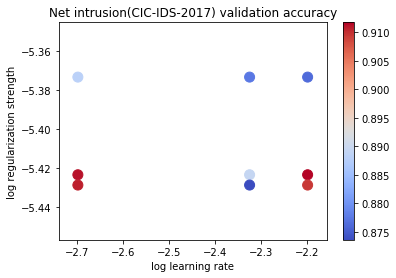

In [98]:
# Visualize the cross-validation results
import math
import matplotlib.pyplot as plt
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]


# plot validation accuracy
marker_size=100
colors = [results[x] for x in results] # default size of markers is 20

plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('Net intrusion(CIC-IDS-2017) validation accuracy')
plt.savefig('/media/juma/code/courses/Semester3/DeepLearning/intrusion_detection/MachineLearningCVE/4rth_run.png')
plt.show()